#  Superpixels and Image Segmentation.

Name: **Satish Vennapu**



----------------------------

In this assignment, you will learn about superpixels. You will first generate superpixels by clustering pixels via k-means. This will generate a superpixel map such as the following:

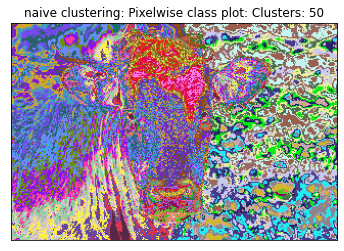

You will then implement a better superpixel algorithm: SLIC, which lets you generate superpixel maps like the following:

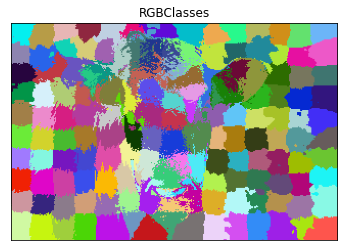

You will then build a segmentation network by training a deep neural network on your superpixels. This part is fairly open-ended, feel free to try any model you can think of (GNN, CNN, Transformer, etc.).

To give an example, for a CNN-based system that reformulates segmentation as superpixel image classification, there are basically three steps in the training stage:

1. Dilate and save each superpixel region from SLIC output into image of size 224X224, alongwith the ground truth segments label.
2. Build a couple of convolution layers to extract the deep features from each Superpixel patch image. Let the last layer be Fully connected layers.
3. Define the segmentation loss as multi-class classification loss and train a convolutional neural network based classifier.

Then, during inference, you would combine the classifier's predicted labels to form the whole input image's Superpixel segmentation results.

## Part 1: Superpixels

For this first part of the assignment, you will implement 2 superpixels methods: k-means pixel clustering, and SLIC.

### Data

First, we download the MSRC labeled imaged database.

In [1]:
!wget http://download.microsoft.com/download/A/1/1/A116CD80-5B79-407E-B5CE-3D5C6ED8B0D5/msrc_objcategimagedatabase_v1.zip
!unzip --qq msrc_objcategimagedatabase_v1.zip

--2023-10-07 01:14:35--  http://download.microsoft.com/download/A/1/1/A116CD80-5B79-407E-B5CE-3D5C6ED8B0D5/msrc_objcategimagedatabase_v1.zip
Resolving download.microsoft.com (download.microsoft.com)... 23.59.203.25, 2600:1406:5400:485::317f, 2600:1406:5400:4a9::317f
Connecting to download.microsoft.com (download.microsoft.com)|23.59.203.25|:80... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://download.microsoft.com/download/A/1/1/A116CD80-5B79-407E-B5CE-3D5C6ED8B0D5/msrc_objcategimagedatabase_v1.zip [following]
--2023-10-07 01:14:35--  https://download.microsoft.com/download/A/1/1/A116CD80-5B79-407E-B5CE-3D5C6ED8B0D5/msrc_objcategimagedatabase_v1.zip
Connecting to download.microsoft.com (download.microsoft.com)|23.59.203.25|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 44119839 (42M) [application/octet-stream]
Saving to: ‘msrc_objcategimagedatabase_v1.zip’

msrc_objcategimaged 100%[===================>]  42.08M  40

For the first part of this assignment, we will only use the following images. We define the list below as `im_list`.

In [2]:
im_list = ['MSRC_ObjCategImageDatabase_v1/1_22_s.bmp',
           'MSRC_ObjCategImageDatabase_v1/1_27_s.bmp',
           'MSRC_ObjCategImageDatabase_v1/3_3_s.bmp',
           'MSRC_ObjCategImageDatabase_v1/3_6_s.bmp',
           'MSRC_ObjCategImageDatabase_v1/6_5_s.bmp',
           'MSRC_ObjCategImageDatabase_v1/7_19_s.bmp']

We provide the following functions as helpers for plotting your results. Please pay attention to their signatures and outputs.





In [3]:
#All important functions to plot
%matplotlib inline
import cv2
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.patches as mpatches

def plot_image(im, title, xticks = [], yticks = [], isCv2 = True):
    """
    im :Image to plot
    title : Title of image
    xticks : List of tick values. Defaults to nothing
    yticks :List of tick values. Defaults to nothing
    cv2 :Is the image cv2 image? cv2 images are BGR instead of RGB. Default True
    """
    plt.figure()
    if isCv2:
        im = im[:,:,::-1]
    plt.imshow(im)
    plt.title(title)
    plt.xticks(xticks)
    plt.yticks(yticks)

def superpixel_plot(im,seg,title = "Superpixels"):
    """
    Given an image (nXmX3) and pixelwise class mat (nXm),
    1. Consider each class as a superpixel
    2. Calculate mean superpixel value for each class
    3. Replace the RGB value of each pixel in a class with the mean value

    Inputs:
    im: Input image
    seg: Segmentation map
    title: Title of the plot

    Output: None
    Creates a plot
    """
    clust = np.unique(seg)
    mapper_dict = {i: im[seg == i].mean(axis = 0)/255. for i in clust}

    seg_img =  np.zeros((seg.shape[0],seg.shape[1],3))
    for i in clust:
        seg_img[seg == i] = mapper_dict[i]

    plot_image(seg_img,title)

    return

def rgb_segment(seg,n = None,plot = True,title=None,legend = True,color = None):
    """
    Given a segmentation map, get the plot of the classes
    """
    clust = np.unique(seg)
    if n is None:
        n = len(clust)
    if color is None:
        cm = plt.cm.get_cmap('hsv',n+1)
        # mapper_dict = {i:np.array(cm(i/n)) for i in clust}
        mapper_dict = {i:np.random.rand(3,) for i in clust}
    #elif color == 'mean':
        #TODO..get the mean color of cluster center and assign that to mapper_dict

    seg_img =  np.zeros((seg.shape[0],seg.shape[1],3))
    for i in clust:
        seg_img[seg == i] = mapper_dict[i][:3]

    if plot:
        plot_image(seg_img,title = title)
    if legend:
        # get the colors of the values, according to the
        # colormap used by imshow
        patches = [ mpatches.Patch(color=mapper_dict[i], label=" : {l}".format(l=i) ) for i in range(n) ]
        # put those patched as legend-handles into the legend
        plt.legend(handles=patches, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0. )
        plt.grid(True)
        plt.show()

    return seg_img

For example, the following code uses `plot_image` to plot the 6 images we are using for this assignment.

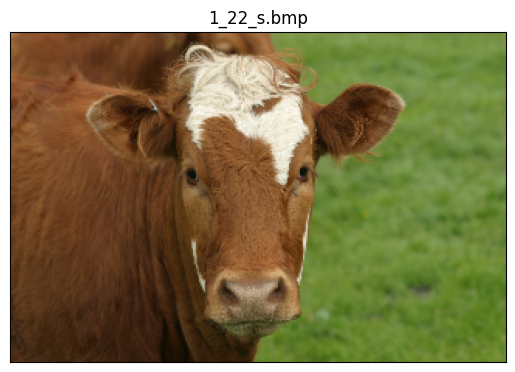

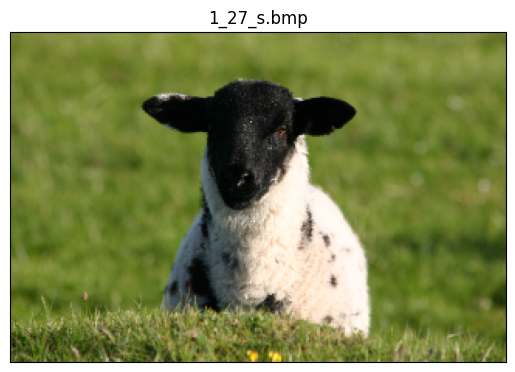

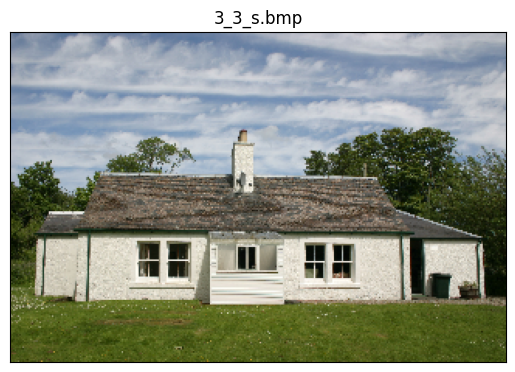

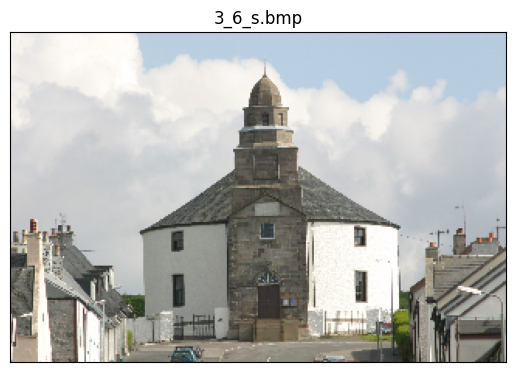

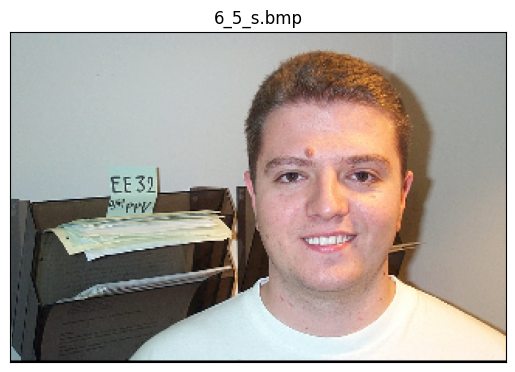

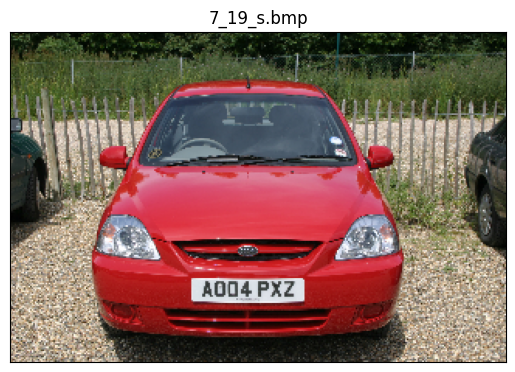

In [4]:
for i in im_list:
    plot_image(cv2.imread(i),i.split("/")[-1])

### Question 1: Perform k-means on image pixels `(r, g, b, x, y)`. (40 points)

The k-means clustering algorithm is an unsupervised algorithm which, for some items and for some specified number of clusters represented by cluster centers, minimizes the distance between items and their associated cluster centers. It does so by iteratively assigning items to a cluster and recomputing the cluster center based on the assigned items.

Complete the pixel clustering function. It should take input an image (shape = `(n, m, 3)`) and number of clusters. Each pixel should be represented by a vector with 3 values: `(r, g, b, x, y)`.

Then, let our provided code plot the pixelwise and superpixel plots for the cow image (`1_22_s.bmp`), using your `cluster_pixels` implementation with the provided values for the number of clusters: `5, 10, 25, 50, 150`.




/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
<ipython-input-3-f18edad7b664>:58: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cm = plt.cm.get_cmap('hsv',n+1)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
<ipython-input-3-f18edad7b664>:58: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` inste

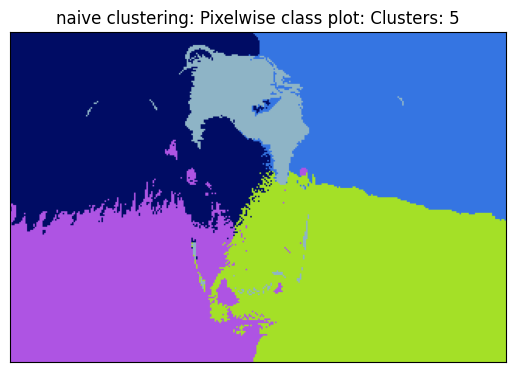

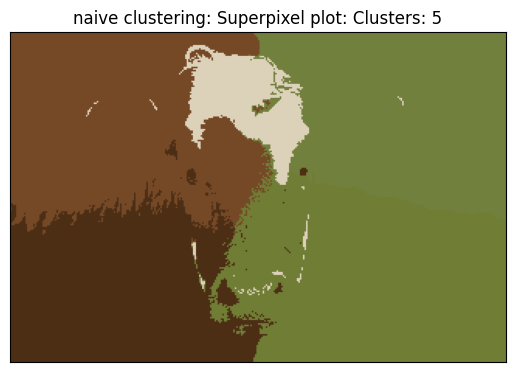

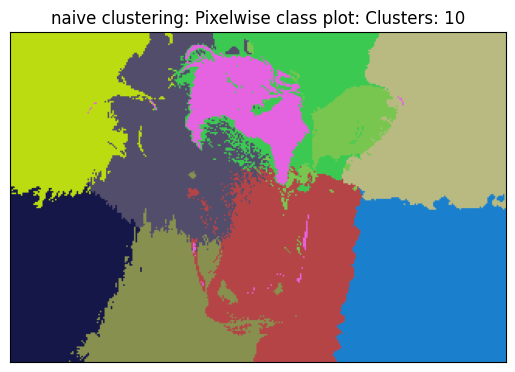

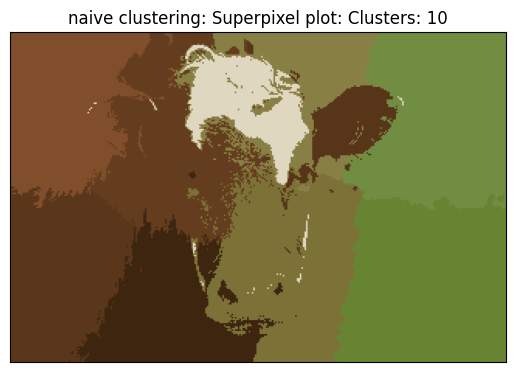

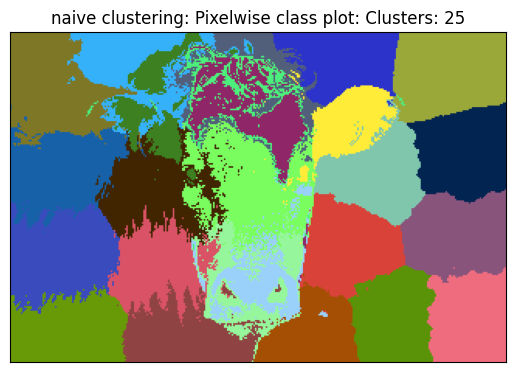

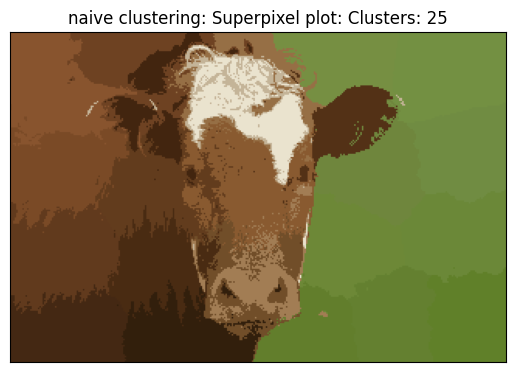

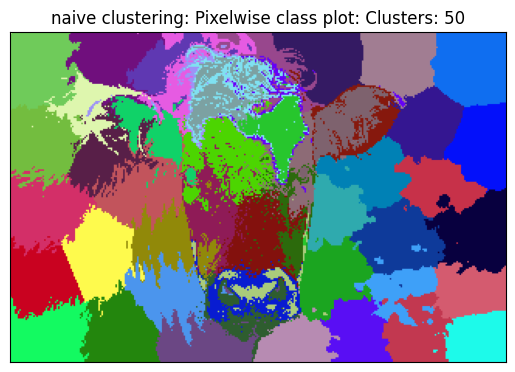

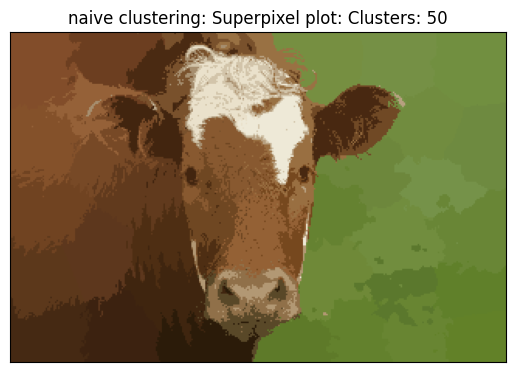

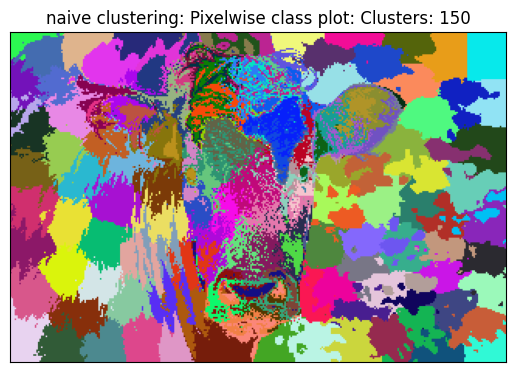

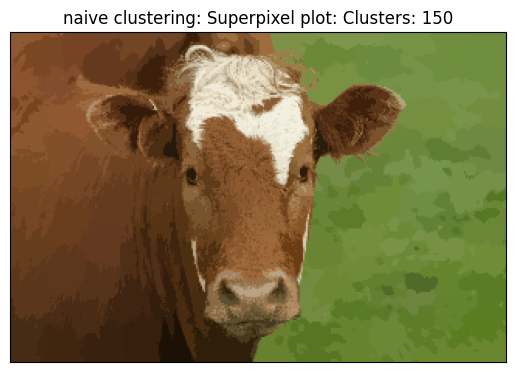

In [5]:
from sklearn.cluster import KMeans
import numpy as  np
import cv2

def preprocessing(im):
    """
    Converts RGB to XYRGB
    """
    mod_im = np.zeros((im.shape[0], im.shape[1], im.shape[2]+2))
    for i in range(mod_im.shape[0]):
      for j in range(mod_im.shape[1]):
        mod_im[i,j] = np.array([i, j, im[i,j][0], im[i,j][1], im[i,j][2]])
    return mod_im

def cluster_rgbxy(im,k):
    """
    Given image im and asked for k clusters, return nXm size 2D array
    segmap[0,0] is the class of pixel im[0,0,:]
    """
    h, w, c = im.shape
    im = im.reshape(h*w, c)
    kmeans_cluster = KMeans(n_clusters=k)
    kmeans_cluster.fit(im)
    cluster_labels = kmeans_cluster.labels_

    #segmap is nXm. Each value in the 2D array is the cluster assigned to that pixel
    return cluster_labels.reshape(h, w)

orginal_im = cv2.imread(im_list[0])
for k in [5, 10, 25, 50, 150]:

    im = preprocessing(orginal_im)
    im = im/255
    clusters = cluster_rgbxy(im,k)
    _ = rgb_segment(clusters,n = k, title =  "naive clustering: Pixelwise class plot: Clusters: " + str(k),legend = False)
    superpixel_plot(orginal_im,clusters,title =  "naive clustering: Superpixel plot: Clusters: "+ str(k))

Pick your favorite superpixel **k** value and plot results for all 6 images in `im_list`.

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
<ipython-input-3-f18edad7b664>:58: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cm = plt.cm.get_cmap('hsv',n+1)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
<ipython-input-3-f18edad7b664>:58: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` inste

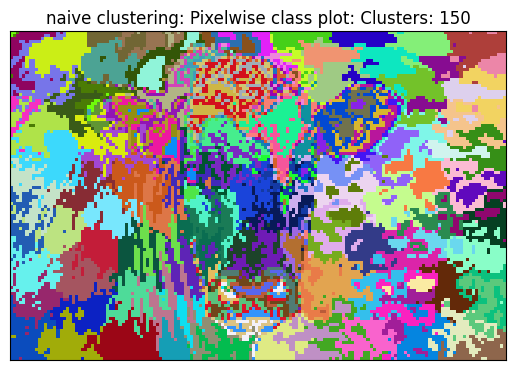

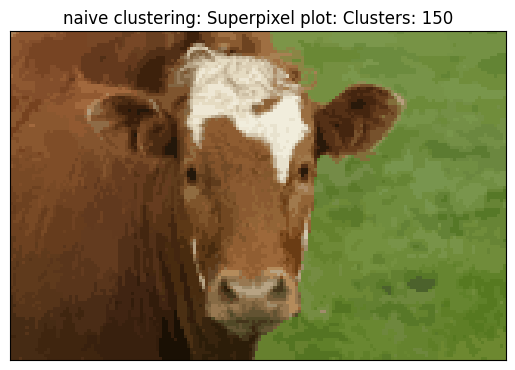

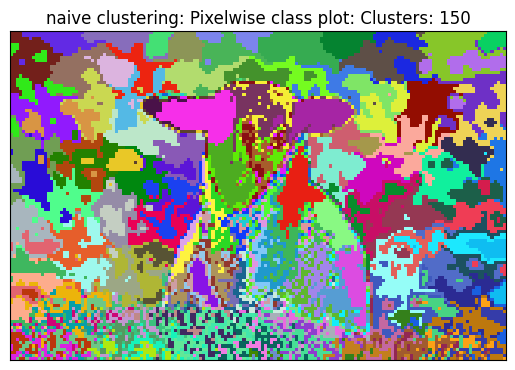

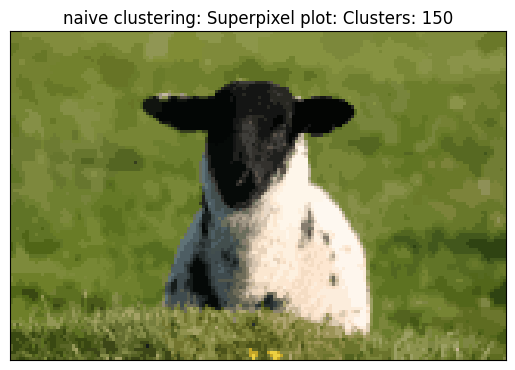

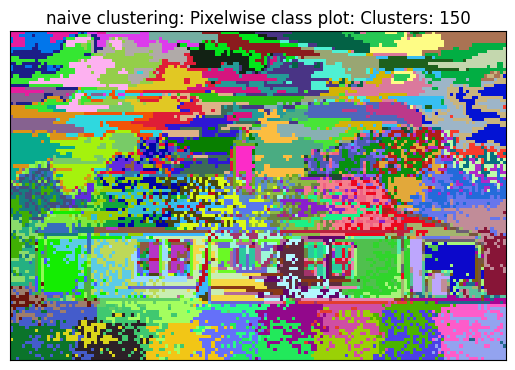

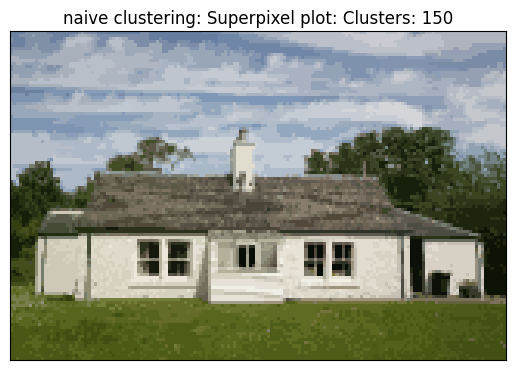

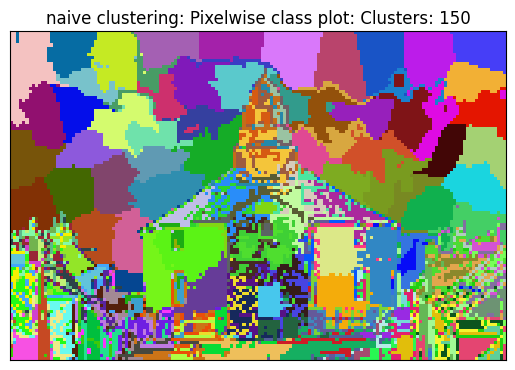

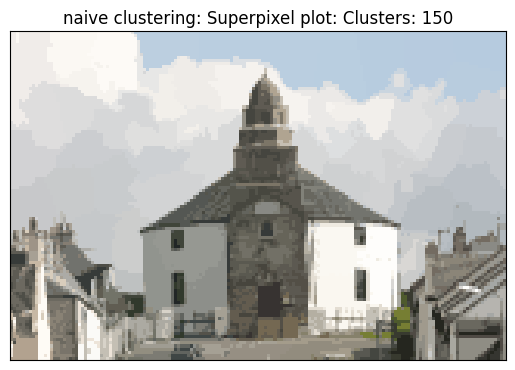

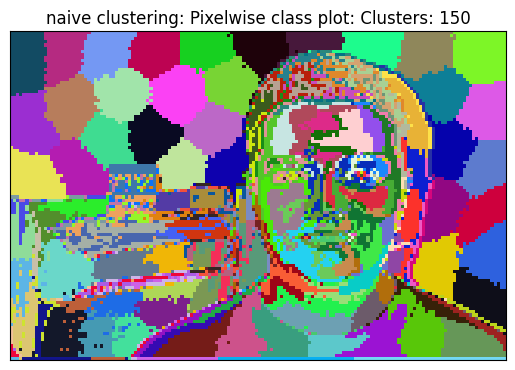

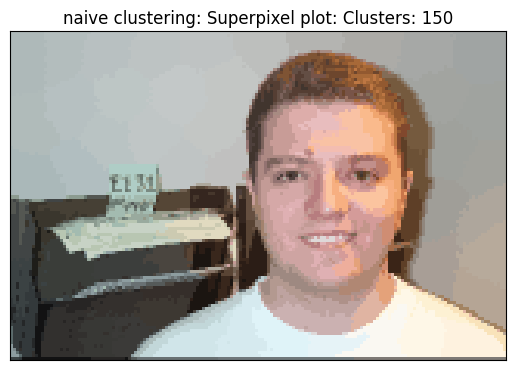

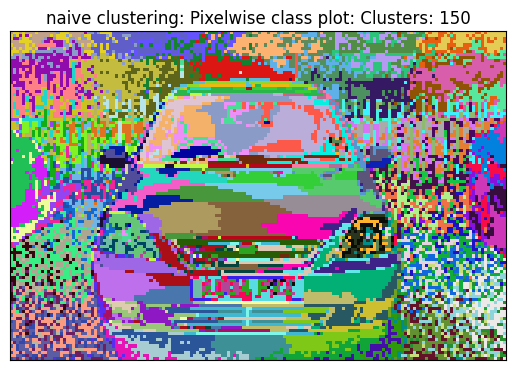

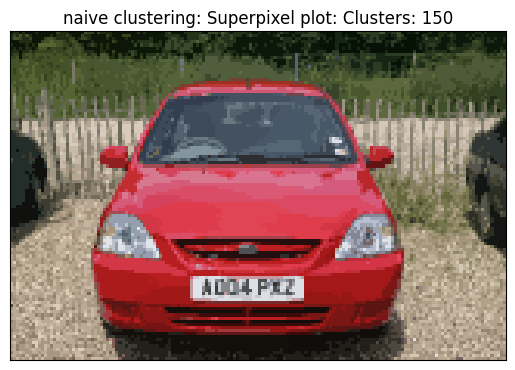

In [6]:
# TODO: plot for 6 images with chosen k value
for orginal_im in im_list:
  orginal_im = cv2.imread(orginal_im)
  width = int(orginal_im.shape[1]*0.5)
  height = int(orginal_im.shape[0]*0.5)

  orginal_im = cv2.resize(orginal_im, (width, height),interpolation = cv2.INTER_AREA)
  im = preprocessing(orginal_im)
  im = im/255
  k = 150
  clusters = cluster_rgbxy(im,k)
  _ = rgb_segment(clusters,n = k, title =  "naive clustering: Pixelwise class plot: Clusters: " + str(k),legend = False)
  superpixel_plot(orginal_im,clusters,title =  "naive clustering: Superpixel plot: Clusters: "+ str(k))

### Question 2: Replicate SLIC and Show Results for 6 Images (50 points)

It doesn't look like we have a very favourable outcome with superpixels being implemented with simple clustering. Can we do better? Have a look at the SLIC paper [here](https://www.iro.umontreal.ca/~mignotte/IFT6150/Articles/SLIC_Superpixels.pdf). Incorporate S and m and redefine your distance metric as per the paper.

**Finding an existing implementation of SLIC and using it for your assigment would be considered cheating.**

In [7]:
############Algorithm############
#Compute grid steps: S
#you can explore different values of m
#initialize cluster centers [l,a,b,x,y] using
#Perturb for minimum G
#while not converged
##for every pixel:
####  compare distance D_s with each cluster center within 2S X 2S.
####  Assign to nearest cluster
##calculate new cluster center

import numpy as np
from skimage import color
import cv2
import sys

def cluster_centre_initialization(im, S):
    """
    Uniform cluster centre initialization at S distance apart
    """
    # Uniform initialization of means 2d matrix with cluster centres at S distance apart
    cluster_centres = []

    for x in range(int(S),im.shape[0],int(S)):
        for y in range(int(S),im.shape[1],int(S)):
            cluster_centres.append([x,y])

    return cluster_centres

def gradient(im):
    """
    Function to calculate the gradient for LAB vector
    """

    grad = np.zeros((im.shape[0], im.shape[1]))

    for x in range(1, im.shape[0]-1):
      for y in range(1, im.shape[1]-1):
          X, Y = [], []
          for i in range(3):
              X.append(im[x+1, y, i] - im[x-1, y, i])
              Y.append(im[x, y+1, i] - im[x, y-1, i])

          grad[x,y] = np.linalg.norm(X) + np.linalg.norm(Y)

    return grad


def mean_perturbation(grad, cluster_centres):
    """
    Function to perturbate the cluster_centres to lowest gradients
    """
    for i in range(len(cluster_centres)):

        # indexing nearby 3*3 region
        sub_array = grad[cluster_centres[i][0]-3 : cluster_centres[i][0]+3, cluster_centres[i][1]-3 : cluster_centres[i][1]+3]

        # Finding min gradient
        index = np.where(sub_array==sub_array.min())

        # Assigning the cluster centre to min gradient index
        change = list(zip(index[0],index[1]))[0]
        cluster_centres[i] = [cluster_centres[i][0]-3 + change[0], cluster_centres[i][1]-3 + change[1]]

    return cluster_centres


def weighted_distance(m, S, l1, a1, b1, x1, y1, l2, a2, b2, x2, y2):
    """
    This function is used to calculate the weighted euclidean distance from lab and xy coordinates
    """
    lab_distance = ((l1-l2)**2 + (a1-a2)**2 + (b1-b2)**2)**0.5
    cood_distance = ((x1-x2)**2 + (y1-y2)**2)**0.5

    distance = lab_distance + (m/S)*cood_distance
    return distance


def SLIC(im, k):
    """
    Input arguments:
    im: image input
    k: number of cluster segments


    Compute
    S: As described in the paper
    m: As described in the paper (use the same value as in the paper)
    follow the algorithm..

    returns:
    segmap: 2D matrix where each value corresponds to the image pixel's cluster number
    """

    # Parameter initialization
    N = im.shape[0]*im.shape[1]  # no. of pixels
    S = (N/k)**0.5               # Average length of superpixels
    m = 10                       # Parameter to assign weight to the spatial distance

    # RGB to LAB space
    lab = color.rgb2lab(im)

    # Cluster Centre initialization
    cluster_centres = cluster_centre_initialization(lab, S)

    # Calculating gradient
    grad = gradient(lab)


    cluster_centres = mean_perturbation(grad, cluster_centres)

    # SLIC algorithm
    segmap = np.zeros((im.shape[0], im.shape[1]))

    for i in range(10):                     # convergence loop
        # iterating over each pixel
        for x in range(im.shape[0]):
           for y in range(im.shape[1]):

                # To find cluster centres within 2S distance
                near_clusters = []
                for cluster in cluster_centres:
                    dist = ((x-cluster[0])**2 + (y-cluster[1])**2)**0.5
                    if dist <= 2*S:
                        near_clusters.append(cluster)

                # Finding the min distance cluster from near clusters
                if near_clusters:
                    distance_array = []
                    for cluster in near_clusters:
                        l1, a1, b1 = lab[x,y]
                        x1, y1 = x, y
                        l2, a2, b2 = lab[cluster[0], cluster[1]]
                        x2, y2 = cluster[0], cluster[1]
                        dist = weighted_distance(m, S, l1, a1, b1, x1, y1, l2, a2, b2, x2, y2)
                        distance_array.append(dist)

                    min_cluster_centre = near_clusters[np.argmin(distance_array)]

                # Assigining the min_cluster_center to the current pixel
                for i in range(len(cluster_centres)):
                    if list(cluster_centres[i]) == list(min_cluster_centre):
                        segmap[x,y] = i

        # Calculating new cluster centres using assigned index values to pixels
        for index in range(len(cluster_centres)):
            chunk = np.where(segmap==index)
            if len(chunk[0])!=0:
                cluster_centres[index] = np.array([int(np.mean(chunk[0])),int(np.mean(chunk[1]))])

    return S, cluster_centres, lab, segmap


With SLIC implemented, plot results for all 6 images.

<ipython-input-3-f18edad7b664>:58: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cm = plt.cm.get_cmap('hsv',n+1)


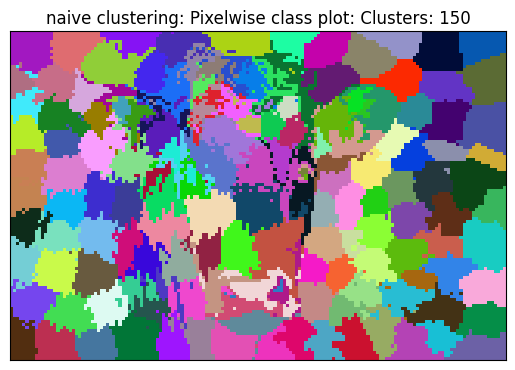

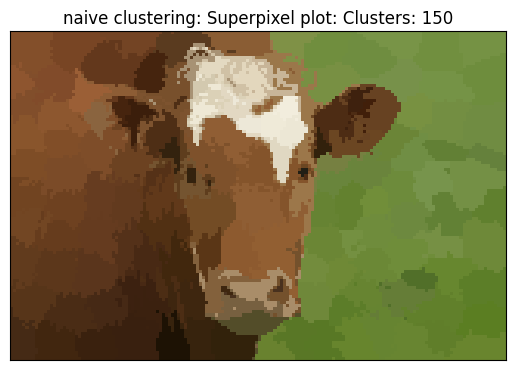

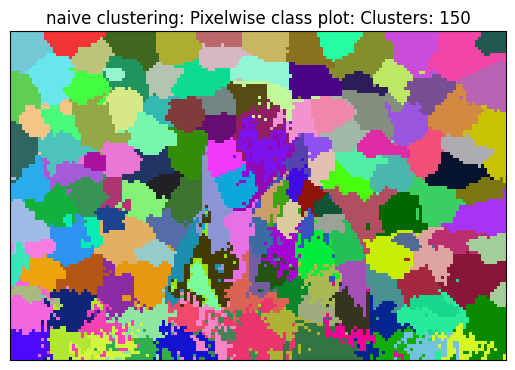

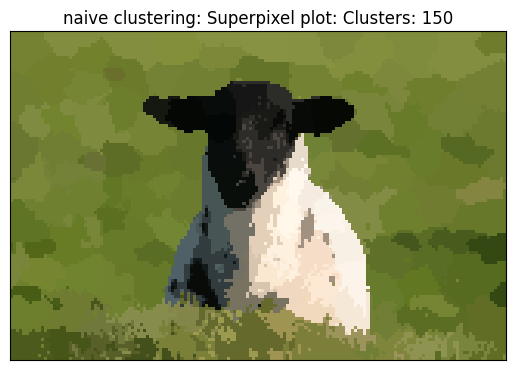

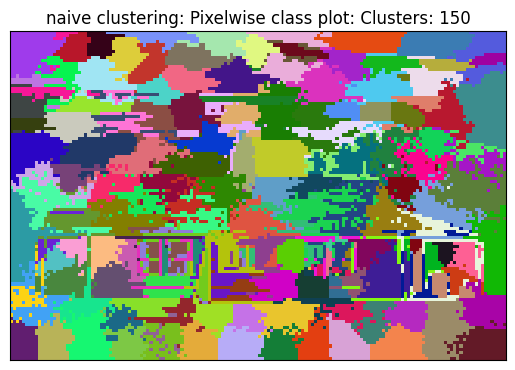

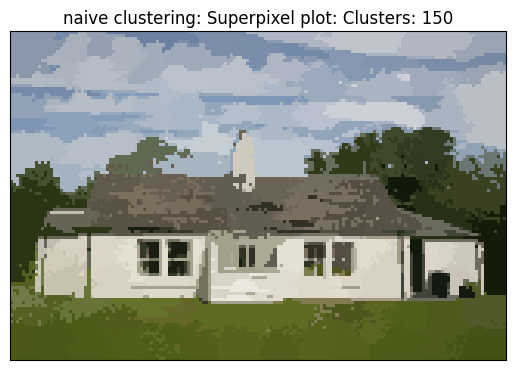

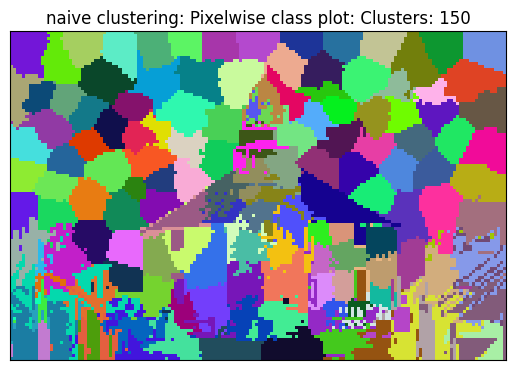

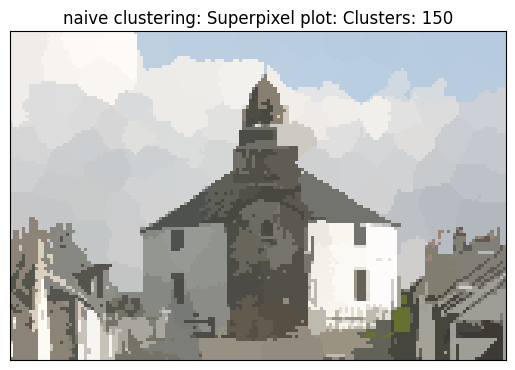

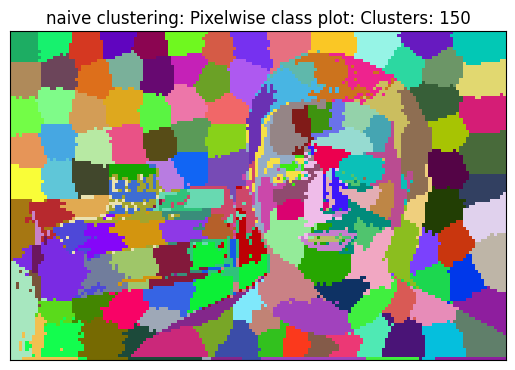

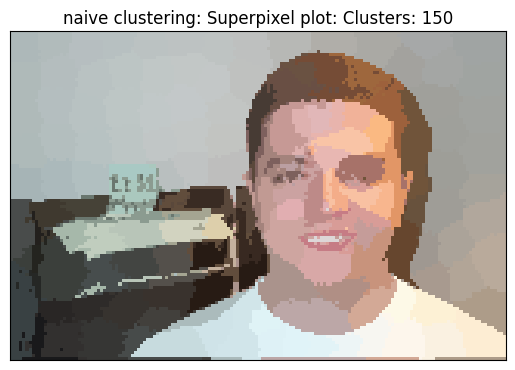

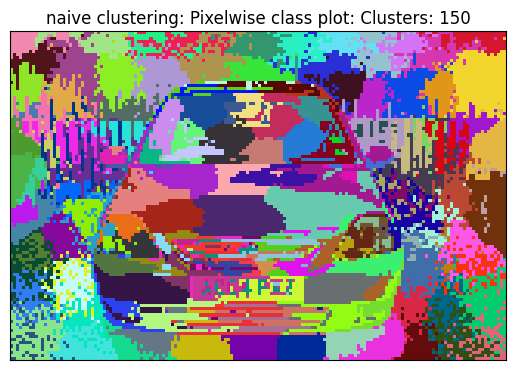

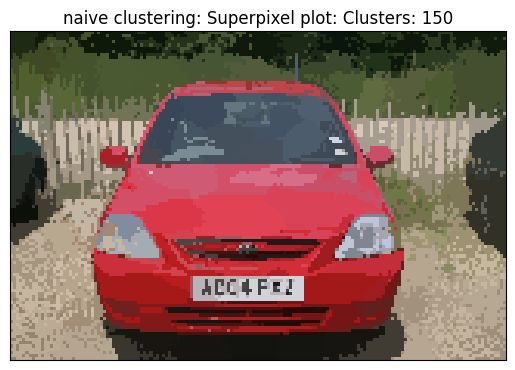

In [8]:
## TODO: Call our plot functions with your SLIC results for all 6 images
image_params = []
for orginal_im in im_list:
  orginal_im = cv2.imread(orginal_im)
  width = int(orginal_im.shape[1]*0.5)
  height = int(orginal_im.shape[0]*0.5)

  orginal_im = cv2.resize(orginal_im, (width, height),interpolation = cv2.INTER_AREA)
  im = preprocessing(orginal_im)
  im = im/255
  k = 150
  S, cluster_centres, lab, segmap = SLIC(orginal_im, k)
  image_params.append([orginal_im, S, cluster_centres, lab, segmap])
  _ = rgb_segment(segmap, n = k, title =  "naive clustering: Pixelwise class plot: Clusters: " + str(k),legend = False)
  superpixel_plot(orginal_im, segmap, title =  "naive clustering: Superpixel plot: Clusters: "+ str(k))

### Question 3: What advantage did the SLIC give compared to `(r, g, b, x, y)`? Please answer in 3 sentences or fewer. (10 points)


Your Answer: SLIC generates superpixels that are more compact and regular in shape compared to using just spatial coordinates and RGB values. It achieves this efficiency by clustering pixels in a simplified feature space, reducing the overall number of comparisons. It has advantanges when precise boundaries and fine details are crucial.

### Bonus Question 4: Enforce connectivity (20 points, OPTIONAL)
There are many superpixels which are very small and disconnected from each other. Merge them with larger superpixels

O(N) algorithm:
1. Set minimum size of superpixel
2. If region smaller than threshold, assign to nearest cluster

Plot results for the 6 images.


<ipython-input-3-f18edad7b664>:58: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cm = plt.cm.get_cmap('hsv',n+1)


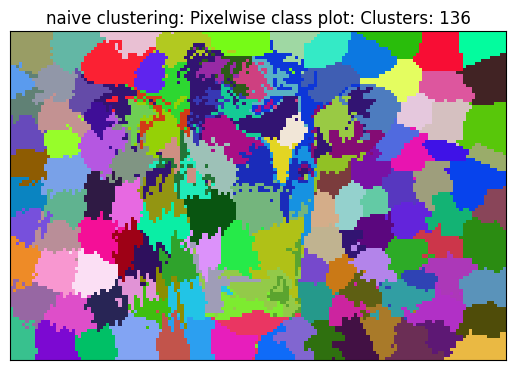

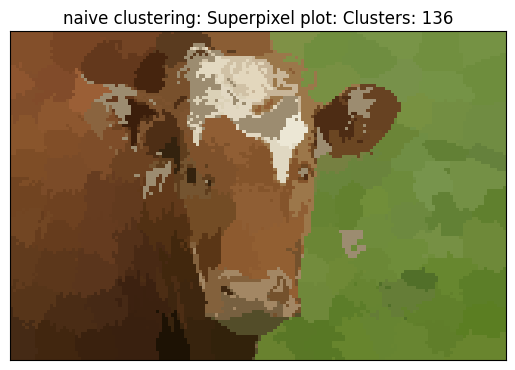

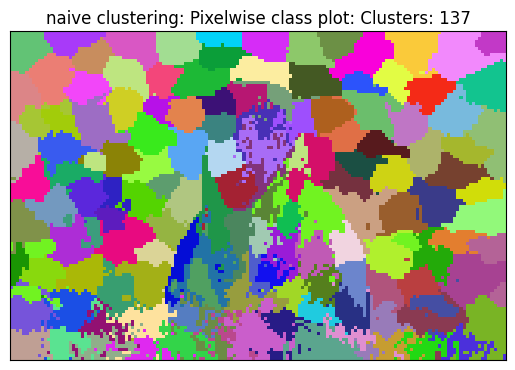

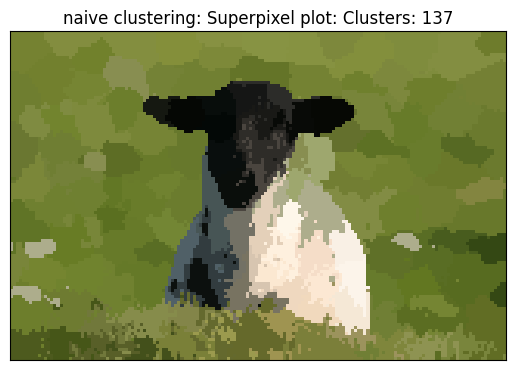

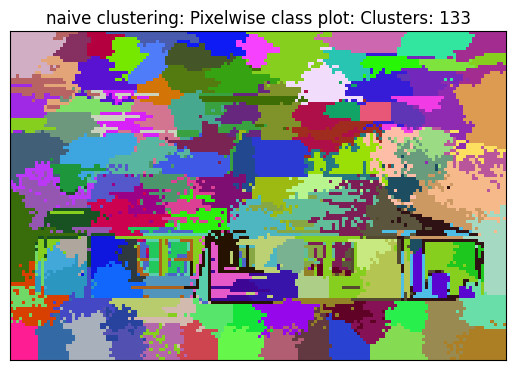

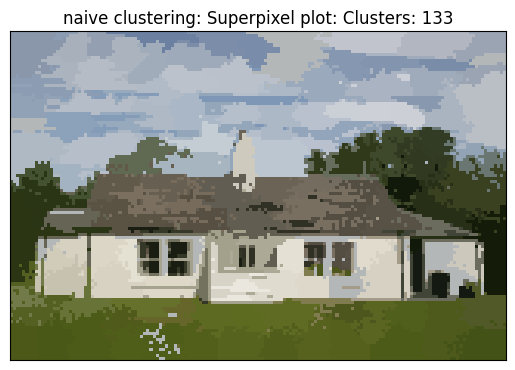

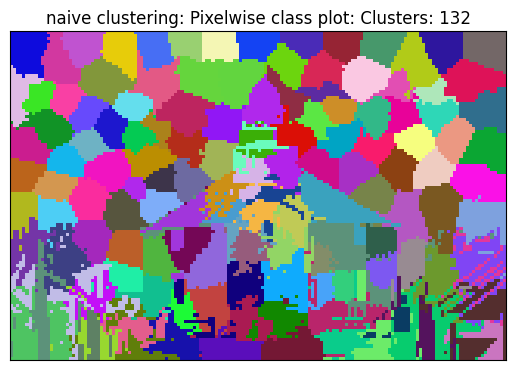

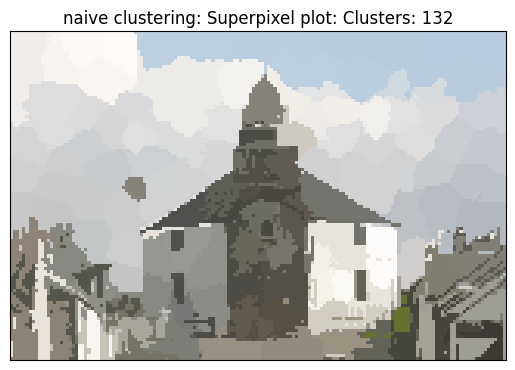

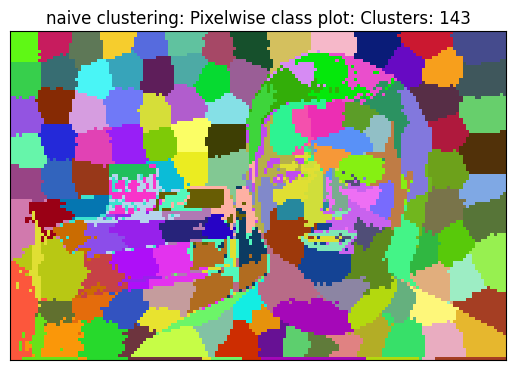

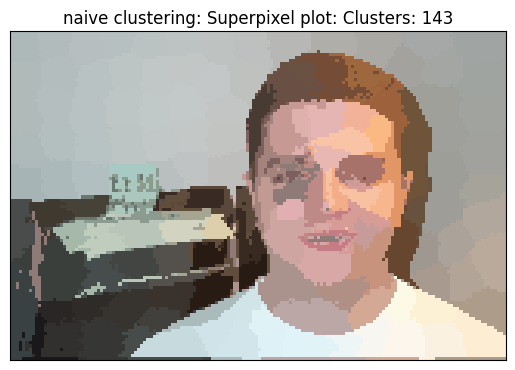

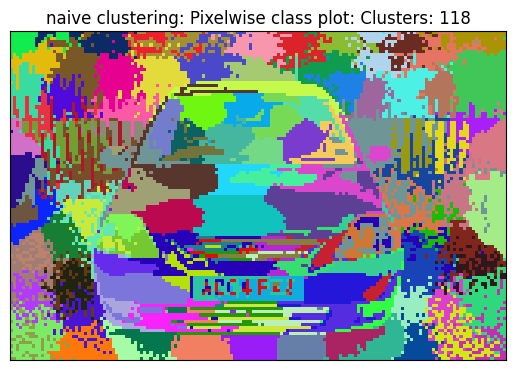

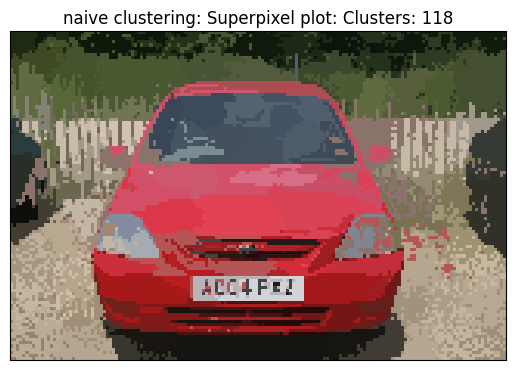

In [9]:

# We use hasharray

def enforce_connectivity(S, cluster_centres, lab, segmap):


    min_area = int(0.5*(S**2))
    hasharray = np.zeros((len(cluster_centres)))
    anomalies = []
    replacement = []
    for x in range(segmap.shape[0]):
        for y in range(segmap.shape[1]):
            hasharray[int(segmap[x,y])] +=1


    for i in range(len(hasharray)):
        if hasharray[i] < min_area and hasharray[i] > 0:
            anomalies.append(i)


    min_distance = sys.maxsize
    for anomaly in anomalies:
        for i in range(len(cluster_centres)):
            if i not in anomalies:
                l1, a1, b1 = lab[cluster_centres[anomaly][0],cluster_centres[anomaly][1]]
                x1, y1 = cluster_centres[anomaly][0], cluster_centres[anomaly][1]
                l2, a2, b2 = lab[cluster_centres[i][0], cluster_centres[i][1]]
                x2, y2 = cluster_centres[i][0], cluster_centres[i][1]
                dis = weighted_distance(10, S, l1, a1, b1, x1, y1, l2, a2, b2, x2, y2)

                if dis < min_distance:
                    min_distance = dis
                    min_cluster = i

        replacement.append(min_cluster)


    for x in range(segmap.shape[0]):
        for y in range(segmap.shape[1]):
            for k in range(len(anomalies)):
                if segmap[x,y] == anomalies[k]:
                    segmap[x,y] = replacement[k]

    return segmap

for image_param in image_params:
    segmap = enforce_connectivity(image_param[1], image_param[2], image_param[3], image_param[4])
    k = len(np.unique(segmap))
    _ = rgb_segment(segmap, n = k, title =  "naive clustering: Pixelwise class plot: Clusters: " + str(k),legend = False)
    superpixel_plot(image_param[0] ,segmap, title =  "naive clustering: Superpixel plot: Clusters: "+ str(k))



## Part 2: Segmentation

For this part, you will use your best superpixels to build an image segmentation system. Alternatively, you can use SLIC from some library, as we demonstrate in the Data section that follows.

### Data

This is mostly the same as the last part, except now we also need to consider the annotated ground truth segmentation maps.

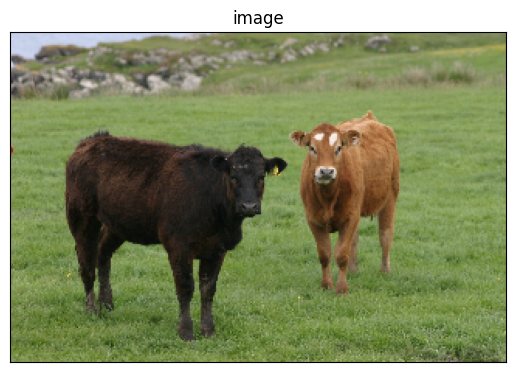

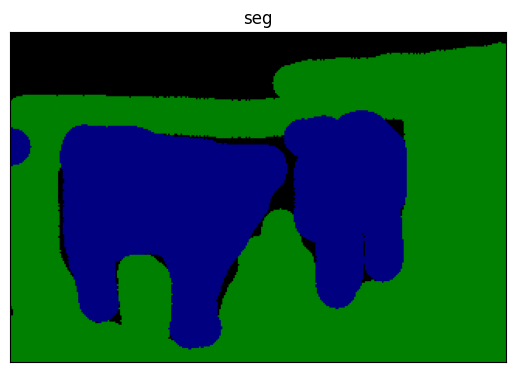

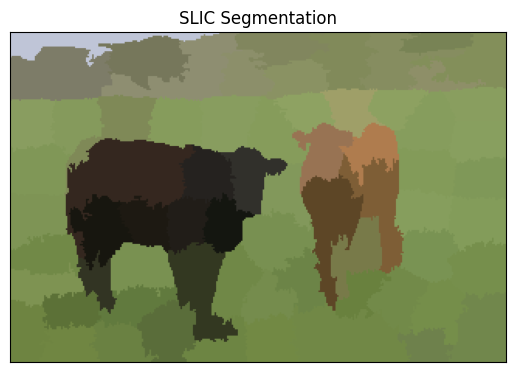

In [10]:
#  plot a sample image and its ground truth segments
image_sample = cv2.imread('MSRC_ObjCategImageDatabase_v1/1_19_s.bmp')
seg_sample = cv2.imread('MSRC_ObjCategImageDatabase_v1/1_19_s_GT.bmp')
plot_image(image_sample, 'image')
plot_image(seg_sample, 'seg')

#  run SLIC on the sample image and plot the corresponding SLIC segments
from skimage.segmentation import slic

segments_sample = slic(image_sample, n_segments=100, compactness=10)
superpixel_plot(image_sample, segments_sample, title = "SLIC Segmentation")

In [21]:
from IPython import embed
import pandas as pd
import os
import cv2
from skimage.segmentation import slic
from skimage.color import label2rgb
from skimage.measure import label
from skimage.measure import regionprops
current_directory = os.getcwd()
msrc_directory = current_directory + '/MSRC_ObjCategImageDatabase_v1'
print(msrc_directory)




#Superpixel dataset preparation

# from Dataset_v1
SEG_LABELS_LIST_v1 = [
    {"id": -1, "name": "void",       "rgb_values": [0,   0,    0]},
    {"id": 0,  "name": "building",   "rgb_values": [128, 0,    0]},
    {"id": 1,  "name": "grass",      "rgb_values": [0,   128,  0]},
    {"id": 2,  "name": "tree",       "rgb_values": [128, 128,  0]},
    {"id": 3,  "name": "cow",        "rgb_values": [0,   0,    128]},
    {"id": 4,  "name": "sky",        "rgb_values": [128, 128,  128]},
    {"id": 5,  "name": "airplane",   "rgb_values": [192, 0,    0]},
    {"id": 6, "name": "face",       "rgb_values": [192, 128,  0]},
    {"id": 7, "name": "car",        "rgb_values": [64,  0,    128]},
    {"id": 8, "name": "bicycle",    "rgb_values": [192, 0,    128]},
    {"id": -1, "name": "horse",       "rgb_values": [128,   0,    128]},
    {"id": -1, "name": "water",       "rgb_values": [64,   128,    0]},
    {"id": -1, "name": "mountain",       "rgb_values": [64,   0,    0]},
    {"id": -1, "name": "sheep",       "rgb_values": [0,   128,    128]}]

# from Dataset_v2
SEG_LABELS_LIST_v2 = [
    {"id": -1, "name": "void",       "rgb_values": [0,   0,    0]},
    {"id": 0,  "name": "building",   "rgb_values": [128, 0,    0]},
    {"id": 1,  "name": "grass",      "rgb_values": [0,   128,  0]},
    {"id": 2,  "name": "tree",       "rgb_values": [128, 128,  0]},
    {"id": 3,  "name": "cow",        "rgb_values": [0,   0,    128]},
    {"id": 4,  "name": "horse",      "rgb_values": [128, 0,    128]},
    {"id": 5,  "name": "sheep",      "rgb_values": [0,   128,  128]},
    {"id": 6,  "name": "sky",        "rgb_values": [128, 128,  128]},
    {"id": 7,  "name": "mountain",   "rgb_values": [64,  0,    0]},
    {"id": 8,  "name": "airplane",   "rgb_values": [192, 0,    0]},
    {"id": 9,  "name": "water",      "rgb_values": [64,  128,  0]},
    {"id": 10, "name": "face",       "rgb_values": [192, 128,  0]},
    {"id": 11, "name": "car",        "rgb_values": [64,  0,    128]},
    {"id": 12, "name": "bicycle",    "rgb_values": [192, 0,    128]},
    {"id": 13, "name": "flower",     "rgb_values": [64,  128,  128]},
    {"id": 14, "name": "sign",       "rgb_values": [192, 128,  128]},
    {"id": 15, "name": "bird",       "rgb_values": [0,   64,   0]},
    {"id": 16, "name": "book",       "rgb_values": [128, 64,   0]},
    {"id": 17, "name": "chair",      "rgb_values": [0,   192,  0]},
    {"id": 18, "name": "road",       "rgb_values": [128, 64,   128]},
    {"id": 19, "name": "cat",        "rgb_values": [0,   192,  128]},
    {"id": 20, "name": "dog",        "rgb_values": [128, 192,  128]},
    {"id": 21, "name": "body",       "rgb_values": [64,  64,   0]},
    {"id": 22, "name": "boat",       "rgb_values": [192, 64,   0]}]

# create a map rgb_2_label, where mapping the ground truth 3-d array segmentation into a single ID label.
rgb_2_label = {}
label_2_rgb = {}
for i in SEG_LABELS_LIST_v1:
    rgb_2_label[tuple(i['rgb_values'])] = i['id']
    label_2_rgb[i['id']] = tuple(i['rgb_values'])

/content/MSRC_ObjCategImageDatabase_v1


### Question 5: Superpixel Dataset (30 points)

First, we dilate each superpixel and save the output superpixel patch from SLIC into 224X224 size image (after rescaling), alongwith the ground truth segments label.

For the purpose of consistency, we adopt the existing SLIC implementation from the scikit-learn machine learning package.

Suggested algorithm: Save the superpixels along with their segmentation class. You could implement this as follows:

For each image
1. Get superpixels sp_i for image x. We adopt 100 segments in this assignment, 'segments = slic(image, n_segments=100, compactness=10)'.
2. For every superpixel sp_i in the image, \\
    2.1. find the smallest rectangle which can enclose sp_i <br>
    2.2. Dilate the rectangle by 3 pixels.<br>
    2.3. Get the same region from the segmentation image (from the file with similar name with *_GT). The class for this sp_i is mode of segmentation classes in that same region. Save the dilated region as npy (jpg is lossy for such small patches).<br>


Alternatively, you could create a single csv with columns segment patch location, class label for each sp_i of each image.<br>italicized text

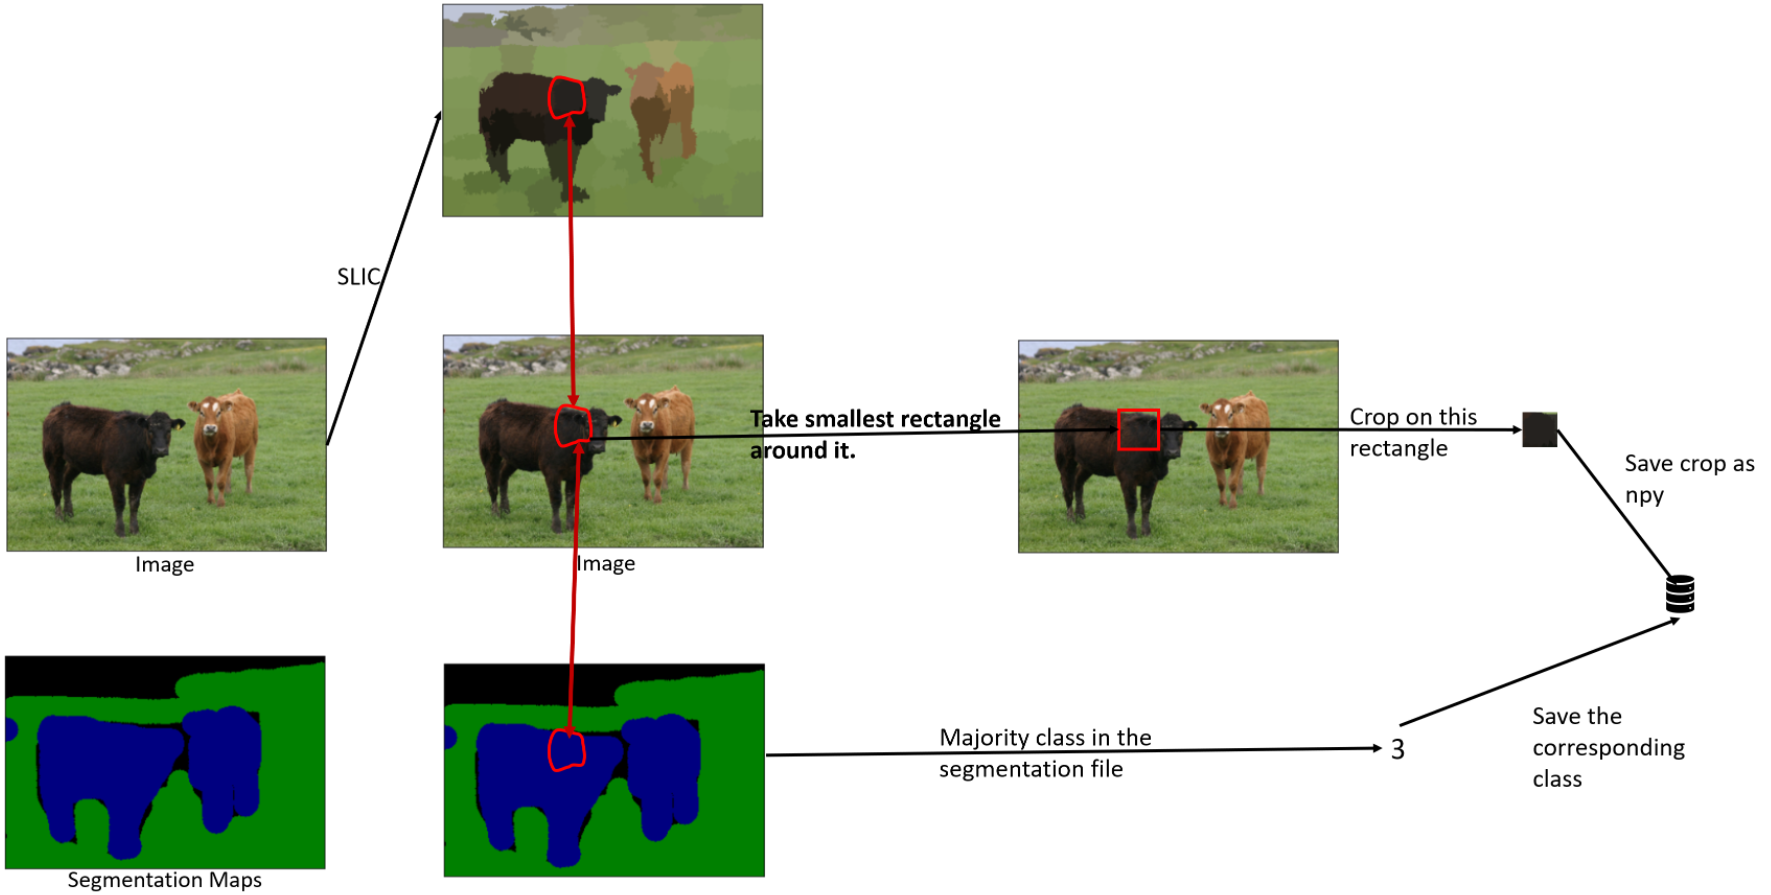


In addition to your code, **the primary graded deliverables** for this question are the 12 demo images we request after you have written code for the dataset.

In [22]:
!mkdir dataset
!mkdir dataset/images
data_directory = current_directory + '/dataset/'

mkdir: cannot create directory ‘dataset’: File exists
mkdir: cannot create directory ‘dataset/images’: File exists


In [23]:
# run SLIC on each original images and save the (segment patch, ID label) pair
# segments = slic(image, n_segments=100, compactness=10)
# it may take up to half an hour to process, depending on the hardware resources
# save the output file names to train.txt
# Alternatively, you don't save the segment patch and ID label offline, instead,
# you process them on the fly later.

# if os.path.exists('./datasets/train.txt'):
#     os.remove('./datasets/train.txt')

# for filename in os.listdir(msrc_directory):
#     # Your code
#     pass
def calc_mode(img):
    unq,count = np.unique(img.reshape(-1,img.shape[-1]), axis=0, return_counts=True)
    return unq[count.argmax()]


if os.path.exists('./datasets/train.txt'):
    os.remove('./datasets/train.txt')

with open(data_directory + '/labels.txt', 'w') as f:

    for filename in os.listdir(msrc_directory):
        if ('bmp' in filename) and ('GT' not in filename):

            image = cv2.imread(msrc_directory + '/' + filename)
            image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

            seg = cv2.imread(msrc_directory + '/' + filename.split('.')[0] + '_GT' + '.bmp')
            seg_rgb = cv2.cvtColor(seg, cv2.COLOR_BGR2RGB)
            segments = slic(image_rgb, n_segments=100, compactness=10)


            image_label_overlay = label2rgb(segments, image=image_rgb)
            # fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(6, 6))
            # ax.imshow(image_label_overlay)

            # Processing each image to extract rectangles from superpixels
            for region in regionprops(segments):
                minr, minc, maxr, maxc = region.bbox

                # Dilate the rectangle by 2 pixels - resolve indexing issues
                minr, minc, maxr, maxc = minr-1, minc-1, maxr+1, maxc+1
                if(minr < 0): minr = 0
                if(minc < 0): minc = 0
                if(maxr == image_rgb.shape[0]): maxr = image_rgb.shape[0]-1
                if(maxc == image_rgb.shape[1]): maxc = image_rgb.shape[1]-1


                # Cropping the image and segmap
                bbox_img = image_rgb[minr:maxr, minc:maxc]
                bbox_seg = seg_rgb[minr:maxr, minc:maxc]

                # Calculating the mode of the cropped image
                mode = calc_mode(bbox_seg)
                label = rgb_2_label[tuple(mode)]

                # Resizing the image to 224*224
                bbox_img = cv2.resize(bbox_img, (224,224), interpolation = cv2.INTER_AREA)

                # Saving the resized image as .npy file and writing to the labels.txt file
                np.save(data_directory + 'images/' + f'{filename}_{regionprops(segments).index(region)}.npy', bbox_img)
                f.write(f'{filename}_{regionprops(segments).index(region)}.npy' + '\t' + str(label) + '\n')



In [24]:
import os
import numpy as np
import torch
import torch.utils.data as data
from PIL import Image
from torchvision import transforms
import _pickle as pickle
import torch.nn as nn
import torchvision.models as models
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau


is_cuda_available = torch.cuda.is_available()
if is_cuda_available:
    print("Using CUDA")
device = torch.device("cuda:0" if is_cuda_available else "cpu")
print(device)

# -------------
# Dataset class
# -------------
#
# ``torch.utils.data.Dataset`` is an abstract class representing a
# dataset.
# Your custom dataset should inherit ``Dataset`` and override the following
# methods:
#
# -  ``__len__`` so that ``len(dataset)`` returns the size of the dataset.
# -  ``__getitem__`` to support the indexing such that ``dataset[i]`` can
#    be used to get sp_i sample
#
# Let's create a dataset class for our superpixel dataset. We will
# read the csv in ``__init__`` but leave the reading of images to
# ``__getitem__``. This is memory efficient because all the images are not
# stored in the memory at once but read as required.
#
# Sample of our dataset will be a dict
# ``{'superpixel image': image, 'superpixel class': class}``. Our dataset will take an
# optional argument ``transform`` so that any required processing can be
# applied on the sample. Remember to resize the image using ``transform``.


class SegmentationData(data.Dataset):

    def __init__(self, txt_file, img_dir, transform=None):
        self.ground_truth_values = self.preprocess(txt_file)
        self.img_dir = img_dir
        self.transform = transform

    def __len__(self):
        return len(self.ground_truth_values)


    def __getitem__(self, index):

        if torch.is_tensor(index):
            index = index.tolist()

        img_path = os.path.join(self.img_dir, self.ground_truth_values[index][0])
        image = np.load(img_path)
        # Remember this processing step
        image = np.clip(np.asarray(image, dtype=float)/255, 0, 1)
        label = self.ground_truth_values[index][1]
        label = int(label)


        if self.transform:
            image = self.transform(image)

        sample = {'superpixel_image': image, 'superpixel_class': torch.tensor(label, dtype=torch.long)}
        return sample

    def image_name(self,index):
        return self.ground_truth_values[index][0]

    def preprocess(self,txt_file):
        data = open(txt_file, encoding='utf8').read().split('\n')
        data = [line for line in data]
        data = [item.split('\t') for item in data]
        return data[:-1] #Drop last item

class ToTensor(object):
    """Convert ndarrays in sample to Tensors."""

    def __call__(self, image):
        # swap color axis because
        # numpy image: H x W x C
        # torch image: C x H x W
        image = image.transpose((2, 0, 1))
        return torch.from_numpy(image)


Using CUDA
cuda:0


Show some outputs! Choose 1 image. For that image, plot the image, along with the superpixel map for the image, as you did for Assignment 1. Then, show the first 10 superpixel patches for the image, retrieved from your dataset.

The output for this portion will be 12 images, displayed below your code below.

6_29_s.bmp_0.npy


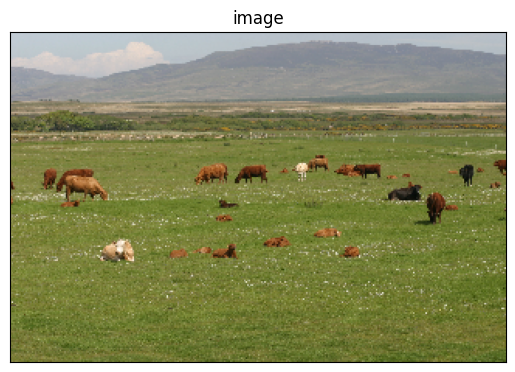

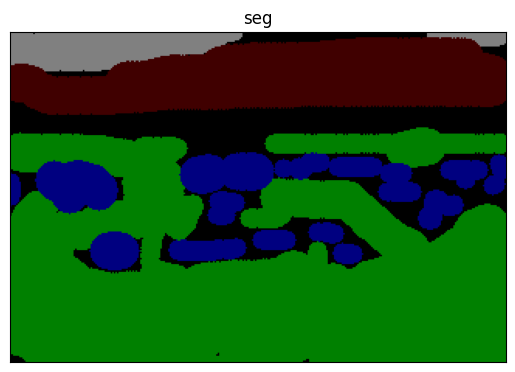

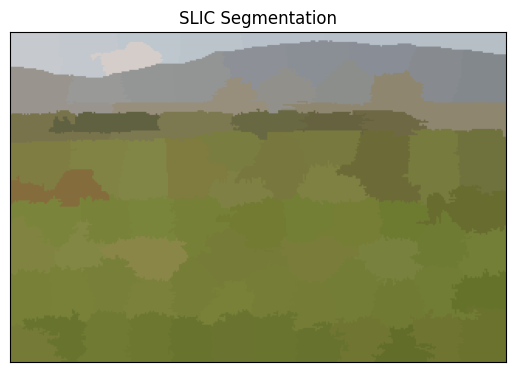

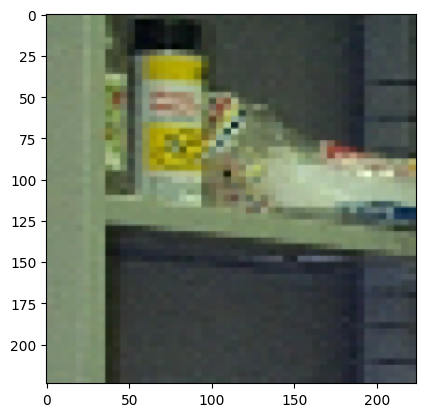

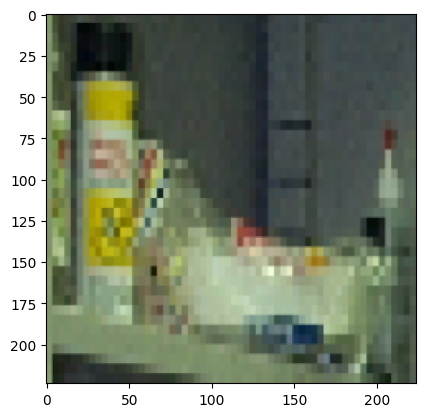

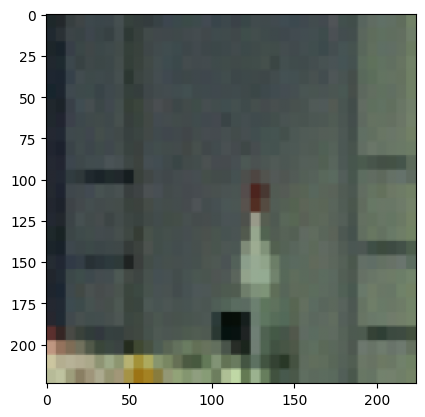

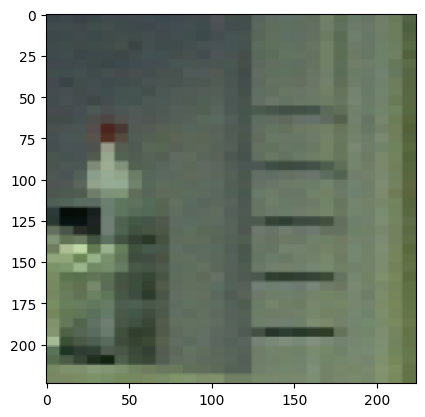

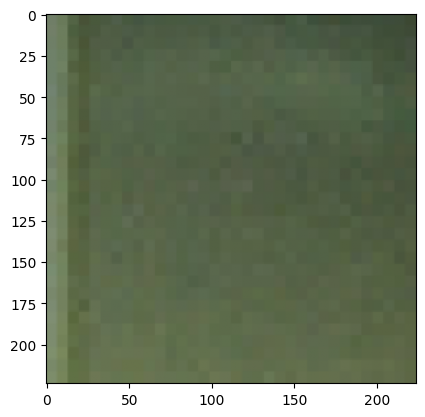

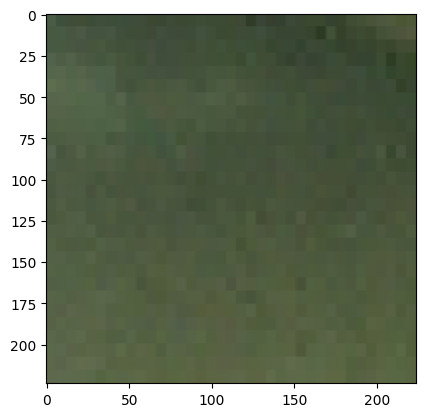

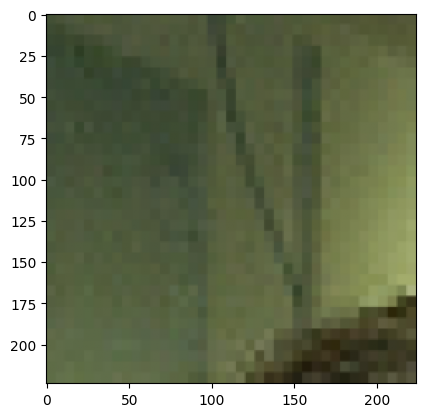

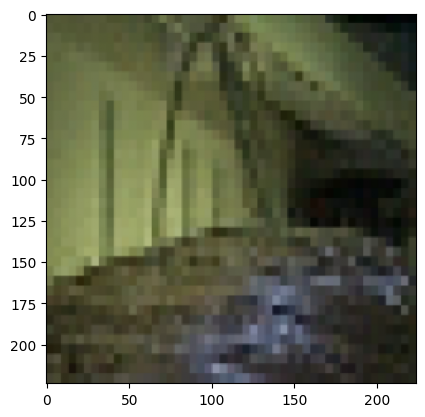

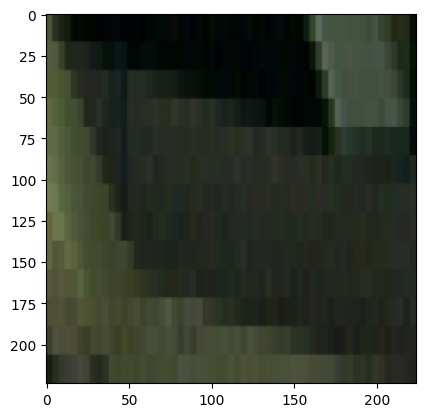

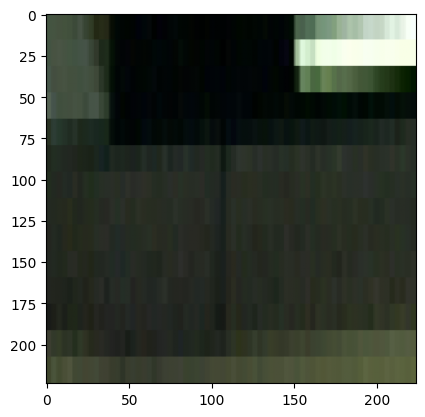

In [25]:
### YOUR CODE TO PLOT 12 images (original RGB + superpixel map + first 10 superpixels) ###
txt_file =  data_directory + '/labels.txt'
img_dir = data_directory + '/images'
dataset = SegmentationData(txt_file, img_dir)
print(dataset.image_name(0))

image_sample = cv2.imread(msrc_directory + '/1_10_s.bmp')
seg_sample = cv2.imread(msrc_directory + '/1_10_s_GT.bmp')
plot_image(image_sample, 'image')
plot_image(seg_sample, 'seg')

segments_sample = slic(image_sample, n_segments=100, compactness=10)
superpixel_plot(image_sample, segments_sample, title = "SLIC Segmentation")
plt.show()

# Printing the first 10 superpixels:
for i in range(10):
    plt.imshow(dataset[i]['superpixel_image'])
    plt.show()

In [37]:
model = models.vgg19(pretrained=True)
model.classifier

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Sequential(
  (0): Linear(in_features=25088, out_features=4096, bias=True)
  (1): ReLU(inplace=True)
  (2): Dropout(p=0.5, inplace=False)
  (3): Linear(in_features=4096, out_features=4096, bias=True)
  (4): ReLU(inplace=True)
  (5): Dropout(p=0.5, inplace=False)
  (6): Linear(in_features=4096, out_features=1000, bias=True)
)

### Question 6: Deep Network (10 points)

You could use a pre-trained network (like VGG) and replace the last few layers with a fully connected layer.

In [38]:
# Model definition
# Model definition
class SegmentationNN(nn.Module):
    def __init__(self):
        super(SegmentationNN, self).__init__()
        self.model = models.vgg19(pretrained=True)
        self.model.classifier = nn.Sequential(
                  nn.Linear(512*7*7, 2048),
                  nn.LeakyReLU(True),
                  nn.Dropout(0.5),
                  nn.Linear(2048, 500),
                  nn.LeakyReLU(True),
                  nn.Dropout(0.7),
                  nn.Linear(500, 10))

        for param in self.model.features.parameters():
            param.requires_grad = False


    def forward(self, input):
        output = self.model(input)
        return output


# For cuda
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

vgg = models.vgg16(pretrained = True, progress = True)
for param in vgg.parameters():
    param.required_grads = False
vgg.classifier[6] = nn.Linear(4096, 10)
vgg = vgg.to(device)

### Question 7: Optimizer (10 points)

Finally, we define the classification loss and optimizer such that we can learn a superpixel classifier from the backproporgation algorithm.

In [42]:
# Optimizer
optimizer = torch.optim.SGD(vgg.parameters(), lr = 0.01)

# Loss function
criterion = nn.CrossEntropyLoss()

# Add a learning rate schedule that gets multiplied by Gamma after every 50 epochs
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size = 100, gamma = 0.1)

### Question 8: Putting it together (50 points)

Train your network and observe the loss in time.
During the inference stage, combine the SLIC Superpixels' predicted labels to form the whole input image's superpixel segmentation results.
The following 4 items are the primary graded components:

1. You must randomly split the whole dataset into train and test subset (80:20 split is fine).
2. You must show the training loss of the classifier after every epoch
3. You must show the training accuracy and test accuracy of the classifier after training.
4. You must plot as least one visualization showing the test segmentation map vs. ground truth segmentation map.

In [ ]:
# Transforms
import time
transform = transforms.Compose([
    transforms.RandomCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
])

# load the data
dataset = dataset(csv_file = 'superpixel_dataset.csv',
                              root_directory = 'Cropped_Superpixels', transform = transform)
# 80-20 Split
train_set, test_set = torch.utils.data.random_split(dataset, [9158, 2290])

# data loader
train_loader = data.DataLoader(dataset = train_set, batch_size = 16, shuffle = True)
test_loader = data.DataLoader(dataset = train_set, batch_size = 1, shuffle = True)

# train the model
# The start time of execution
start_time = time.time()

epochs = 100

train_losses = []
test_losses = []
train_correct = []
test_correct = []

for i in range(epochs):
    trn_corr = 0
    tst_corr = 0
    total_train = 0
    total_test = 0
    lr_scheduler.step()
    for b, (x_train, y_train) in enumerate(train_loader):

        b+=1
        x_train, y_train = x_train.to(device), y_train.to(device)

        y_pred = vgg(x_train)
        loss = criterion(y_pred , y_train)

        # Tally number of correct predictions
        predicted = torch.max(y_pred.data,1)[1]
        batch_corr = (predicted == y_train).sum()
        trn_corr += batch_corr
        total_train += y_train.size(0)

        # Update the Parameters
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()


        if b%50 == 0:
            print(f'epoch: {i:2}  batch: {b}  loss: {loss.item():10.8f}  \
accuracy: {trn_corr.item()*100/total_train:7.3f}% total: {total_train} lr = {lr_scheduler.get_lr()}')

    train_losses.append(loss)
    train_correct.append(trn_corr)


In [43]:
current_directory = os.getcwd()
print(current_directory)

/content


In [48]:
!mkdir models
PATH = current_directory + '/models/seg_network_32.pt'
torch.save(model.state_dict(), PATH)

mkdir: cannot create directory ‘models’: File exists


In [49]:
model.load_state_dict(torch.load(PATH))
model.eval()

SegmentationNN(
  (model): VGG(
    (features): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU(inplace=True)
      (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (6): ReLU(inplace=True)
      (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (8): ReLU(inplace=True)
      (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): ReLU(inplace=True)
      (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (13): ReLU(inplace=True)
      (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (15): ReLU(inplace=True)
     

KeyError: ignored

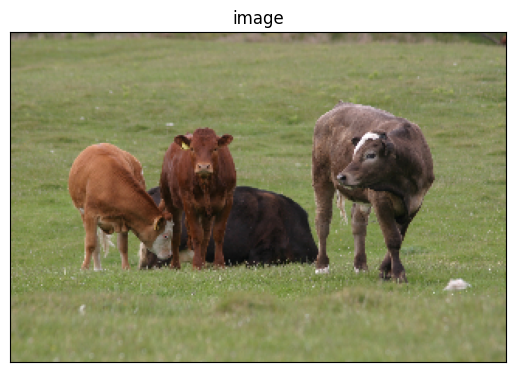

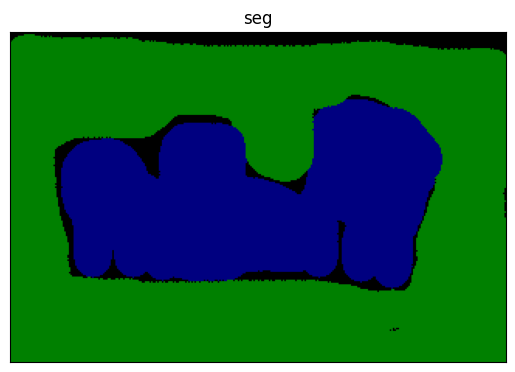

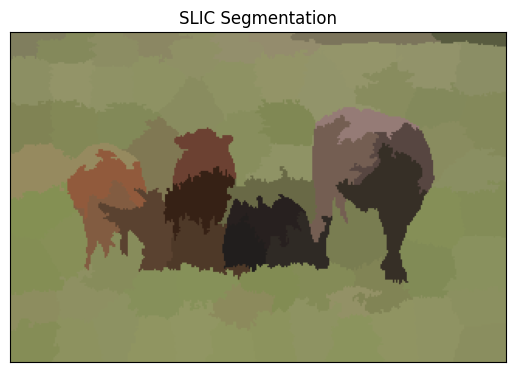

In [58]:
# Evaluation
image_rgb = cv2.imread('MSRC_ObjCategImageDatabase_v1/1_14_s.bmp')
seg_sample = cv2.imread('MSRC_ObjCategImageDatabase_v1/1_14_s_GT.bmp')
plot_image(image_rgb, 'image')
plot_image(seg_sample, 'seg')

segments_sample = slic(image_rgb, n_segments=100, compactness=10)
superpixel_plot(image_rgb, segments_sample, title = "SLIC Segmentation")
# Processing each image to extract rectangles from superpixels

superpixel_data = []
for region in regionprops(segments_sample):
    minr, minc, maxr, maxc = region.bbox

    # Dilate the rectangle by 2 pixels - resolve indexing issues
    minr, minc, maxr, maxc = minr-1, minc-1, maxr+1, maxc+1
    if(minr < 0): minr = 0
    if(minc < 0): minc = 0
    if(maxr == image_rgb.shape[0]): maxr = image_rgb.shape[0]-1
    if(maxc == image_rgb.shape[1]): maxc = image_rgb.shape[1]-1

    # Cropping the image and segmap
    bbox_img = image_rgb[minr:maxr, minc:maxc]

    # Resizing the image to 224*224
    bbox_img = cv2.resize(bbox_img, (224,224), interpolation = cv2.INTER_AREA)
    bbox_img = np.clip(np.asarray(bbox_img, dtype=float)/255, 0, 1)
    # Applying the transforms
    bbox_img = transform(bbox_img)

    superpixel_data.append({'superpixel_image': bbox_img, 'superpixel_location': (minr, minc, maxr, maxc)})

dataloader = data.DataLoader(superpixel_data, batch_size=32, shuffle=True, num_workers=0)

predicted_seg_map = np.zeros(image_rgb.shape, dtype=np.uint8)

with torch.no_grad():
    for sample_batched in dataloader:
        images, location = sample_batched['superpixel_image'].to(device), sample_batched['superpixel_location']
        # calculate outputs by running images through the network
        outputs = model(images.float())
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)

        for i in range(len(images)):
            rgb = label_2_rgb[int(f'{predicted[i]}')]
            minr, minc, maxr, maxc = location[0][i], location[1][i], location[2][i], location[3][i]
            predicted_seg_map[minr:maxr, minc:maxc, :] = rgb

seg_sample = cv2.cvtColor(seg_sample, cv2.COLOR_BGR2RGB)
# print(np.unique(seg_sample.reshape(-1,seg_sample.shape[-1]), axis=0, return_counts=True))
# print(np.unique(predicted_seg_map.reshape(-1,predicted_seg_map.shape[-1]), axis=0, return_counts=True))
plt.imshow(predicted_seg_map)
plt.title('Predicted Segmentation Map')
plt.show()
# Pixel accuracy
Total_pixels = seg_sample.shape[0]*seg_sample.shape[1]

mask = np.all(predicted_seg_map == seg_sample, axis=2)
# print(mask)
TP = np.where(mask==True)
print("Pixel Accuracy: ", (len(TP[0])/Total_pixels)*100)

### Question 9: Bonus Question (20 points, OPTIONAL):

IMPORTANT: No matter which option you choose, you can earn a maximum of 20 points for this section.

We always want to increase the classifier accuracy and achieve a better performance by building a complicated deep learning model. There are a lot of tricks which are very popular and work in practice. Try to implement either of following two,

1. Could you effictively fuse different deep features from multiple layers in your network? You are welcome to use the pretrained network. Does your network achieve a better accuracy? There are a lot of exploration in the literature, including ION (Inside-Outside Net) [1], Hypercolumns [2], and PixelNet [3]. The following figure illustrates ION architecture combining features from different layers. Can you do similar thing for our Superpixel classifier?

2. Could you build a Multi-resolution network to explore the effectiveness of the multi-scale on the task of Superpixels segmentation? By multi-scale, we mean multiple resolutions of superpixels. See [4] for an example.

[1] Inside-Outside Net: Detecting Objects in Context with Skip Pooling and Recurrent Neural Networks

[2] Hypercolumns for Object Segmentation and Fine-grained Localization

[3] PixelNet: Representationofthe pixels, by the pixels, and for the pixels

[4] Feedforward semantic segmentation with zoom-out features

In [ ]:
# Bonus
